In [25]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from util.experiment import Experiment, load_experiments
from util.plotting import plot_label_clusters
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

In [36]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (valid_images, valid_labels) = fashion_mnist.load_data()
valid_images = valid_images.astype("float32") / 255.0
valid_images = tf.expand_dims(valid_images, axis=-1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [40]:
experiments = load_experiments(with_params={"latent_dim": 2, "beta": 4})
experiments.keys()

dict_keys(['09-05-2022_2030_feel-military-friend-area'])

History tf.Tensor(267.47342, shape=(), dtype=float32)
tf.Tensor([[ 1.4453686 -1.0915073]], shape=(1, 2), dtype=float32)


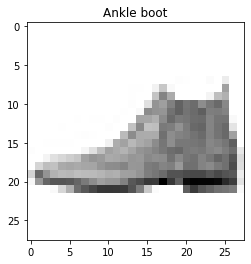

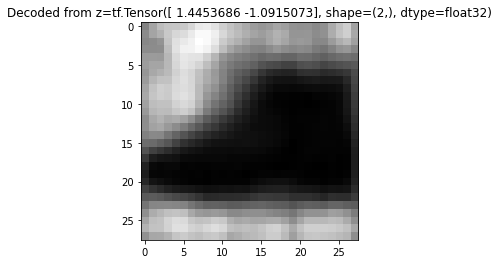

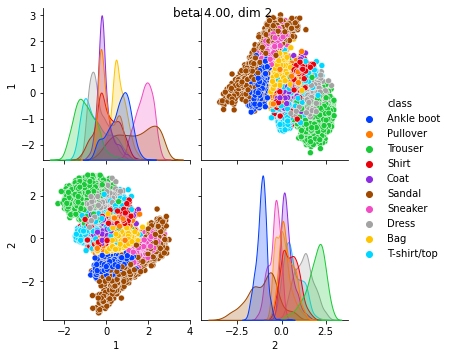

In [53]:
for key in experiments.keys():
    # key = '09-05-2022_2016_feel-major-eye-guy'
    experiment = experiments[key]['experiment']
    print("History", min(experiment.history['train_loss']))
    model = experiment.load_model()
    title = "beta %.2f, dim %d" % (experiment.params['beta'], experiment.params['latent_dim'])

    #plot_label_clusters(model, train_images, train_labels, experiment.vis_dir, title=title, show=True)

    """
    example_data = next(iter(valid_images))
    example_data = tf.expand_dims(example_data, axis=0)
    nex = 8
    zm = 2
    z_mean, _, _ = model.encoder(example_data)
    example_data_reconstructed = model.decoder(z_mean)
    samples = model.decoder(tf.random.normal(shape=(experiment.params['batch_size'], experiment.params['latent_dim'])))
    fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
    for axi, (dat, lab) in enumerate(
        zip(
            [example_data, example_data_reconstructed, samples],
            ["data", "data recon", "samples"],
        )
    ):
        for ex in range(nex):
            axs[axi, ex].matshow(
                dat.numpy()[ex].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
            )
            axs[axi, ex].axes.get_xaxis().set_ticks([])
            axs[axi, ex].axes.get_yaxis().set_ticks([])
        axs[axi, 0].set_ylabel(lab)

    plt.show()
    """
    
    
    x = valid_images[0]
    y = valid_labels[0]

    fig = plt.figure()
    fig = plt.imshow(x, cmap=plt.cm.Greys)
    fig = plt.title(class_names[y])

    z_mean, z_log_var, z_sampled = model.encoder(tf.expand_dims(x, 0))
    print(z_sampled)

    x_decoded = model.decoder(z_mean)
    img = x_decoded[0].reshape(28, 28)
    fig = plt.figure()
    fig = plt.title("Decoded from z=%s" % z_sampled[0])
    fig = plt.imshow(img, cmap=plt.cm.Greys)


    _, _, z = model.encoder(valid_images)
    train_labels_decoded = [class_names[i] for i in valid_labels]
    labels_df = pd.DataFrame(train_labels_decoded, columns = ['class'])
    z_df = pd.DataFrame(z, columns = [str(i) for i in range(1, z.shape[1] + 1)])

    labeled_z_df = pd.concat([labels_df, z_df], axis=1)
    pp = sb.pairplot(labeled_z_df, hue="class", palette=sb.color_palette("bright", 10))
    pp.fig.suptitle(title)

In [30]:
next(iter(valid_images)).shape

(28, 28, 1)

In [35]:

valid_images.shape

TensorShape([10000, 1, 1, 28, 28, 1, 1, 1, 1])